## Credit-card fraud detection

This notebook is about implementing an efficient machine learning model for identifying the fraud transactions. The dataset has been obtained from kaggle(A platform for data science competitions).  The problem is challenging because the dataset is highly imbalanced.

In [118]:
### Importing the libraries ###
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import itertools
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics import roc_auc_score,recall_score,f1_score,precision_score,confusion_matrix,roc_curve,auc
from imblearn.under_sampling import RandomUnderSampler,TomekLinks, ClusterCentroids
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,OneClassSVM
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.ensemble import BaggingClassifier

In [2]:
##### Reading the dataset  ####
data = pd.read_csv('creditcard.csv')
print('The shape of data frame is {}'.format(data.shape))

The shape of data frame is (284807, 31)


In [3]:
### Displaying the sample data ###
data['Type'] = data['Class'].map({0:'Normal',1:'Fraud'})
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Type
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,Normal
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,Normal
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,Normal
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,Normal
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,Normal


In [4]:
### Basic statistics to describe about the data ###
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


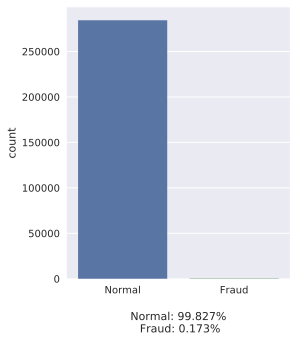

In [5]:
### Visualise the count of each class ###
normal_transaction_percent = (sum(data['Class']==0)/float(data.shape[0]))*100
fraud_transaction_percent = (sum(data['Class']==1)/float(data.shape[0]))*100

_, ax = plt.subplots(figsize=(4,5))
sns.countplot(x='Type', data=data, ax=ax)
plt.xlabel('\n Normal: {:.3f}% \n Fraud: {:.3f}%'.format(normal_transaction_percent,
                                                           fraud_transaction_percent))
plt.show()

**Inference:** The data set is imbalanced. Normal machine learning algorithm will be biased towards the majority class. The usual accuracy metric is also useless for this data set. We will focus on other metric such as cohen Kappa, AUROC and precision.

In [6]:
### Exploring the statistics of Amount for Normal class ###
data.Amount[data['Class']==0].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [7]:
### Exploring the statistics of Amount for Fraud class ###
data.Amount[data['Class']==1].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

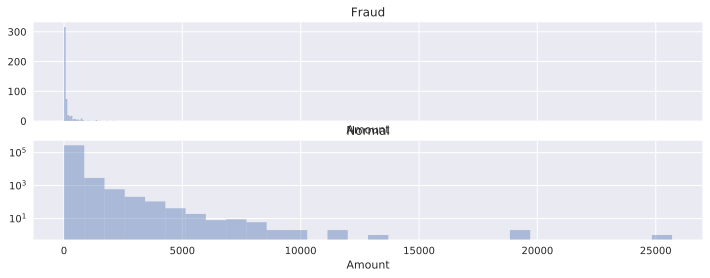

In [8]:
## Exploring transaction amount between noraml and fraud transactions ##
_, ax = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(12,4))
ax[0].set_title('Fraud')
ax[1].set_title('Normal')
sns.distplot(data.Amount[data.Class==1], kde=False, bins=30, ax=ax[0])
sns.distplot(data.Amount[data.Class==0], kde=False, bins=30, ax=ax[1])
plt.yscale('log')
plt.show()

**Inference:** Most of the fraud transactions have are low amount transactions.

In [9]:
### Based on the above observations, we can easily generate a new feature.
exfeature1 = data['Amount'].map(lambda x: 0 if x < 2125.870000 else 1)

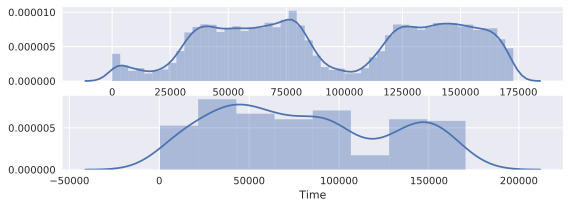

In [10]:
### Exploring the distribution of time within different classes ###
_, ax = plt.subplots(nrows=2,ncols=1, figsize=(9,3))
sns.distplot(data.Time[data.Class==0], ax=ax[0])
sns.distplot(data.Time[data.Class==1], ax=ax[1])
plt.show()

The distribution of time among the both class are almost simillar, so we cannot infer anything meaningful which could be used for feature generation.

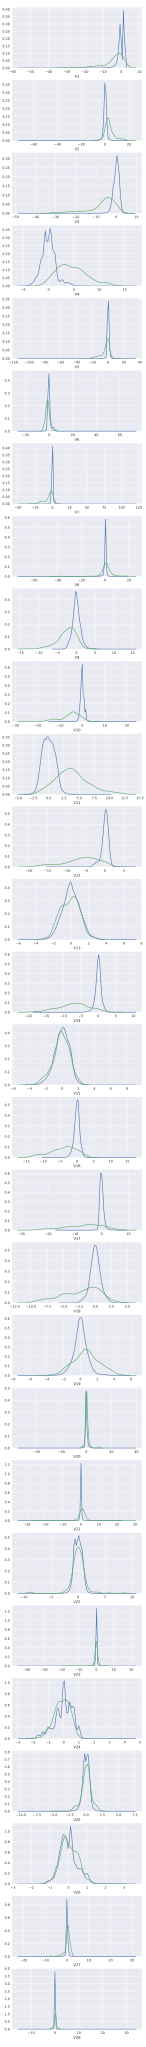

In [11]:
_, ax = plt.subplots(nrows=28,ncols=1, figsize=(7,28*4))

for k,i in enumerate(data.iloc[:,1:29].columns):
    
    sns.distplot(data[data.Class==0][i],hist=False, ax=ax[k])
    sns.distplot(data[data.Class==1][i], hist=False, ax=ax[k])

plt.show()

In [12]:
## We drop the features which have simillar distribution across both the classes.
## Those features are not useful for making decision between fraud and normal. 

feature_to_remove = ['Time','V8','V13','V15','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']
newdata = data.drop(feature_to_remove, axis=1,inplace=False)
newdata.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'Amount', 'Class', 'Type'],
      dtype='object')

In [13]:
### Adding the extra features generated based on the EDA ####
newdata['max_Amount'] = exfeature1


In [14]:
features_to_keep = ['V1','V2','V3','V4','V5','V6','V7','V9','V10','V11','V12','V14','V16','V17',
                   'V18','Amount','max_Amount']
features_to_normalize = ['V1','V2','V3','V4','V5','V6','V7','V9','V10','V11','V12','V14','V16','V17',
                   'V18','Amount']
target = 'Class'


In [55]:
### Splitting the data into train,test and validation ##
X,y = newdata.loc[:,features_to_keep], newdata.loc[:,target]
#X, Xtest,y, ytest = train_test_split(X,y, test_size=0.3)
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.3,
                                                  random_state=0)


In [56]:
### Normalizaing our data set ##
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[features_to_normalize])
X_train_norm = scaler.transform(X_train[features_to_normalize])
X_test_norm = scaler.transform(X_test[features_to_normalize])  


In [57]:
#### Statistics of Validation data set ####
print('The shape of validation data {} '.format(X_test.shape))
print('The number of fraud instances in validation data {} '.format(sum(y_test==1)))
print('The number of normal instances in validation data {} '.format(sum(y_test==0)))

The shape of validation data (85443, 17) 
The number of fraud instances in validation data 147 
The number of normal instances in validation data 85296 


### Utility functions
Some utility functions are created in this section which will be useful in the subsequent sections.

In [58]:

def soft_to_hard(soft,threshold=0.5):
    vfun = np.vectorize(lambda x: 1 if x > threshold else 0)
    hard = vfun(soft)
    return hard

In [59]:
def Sampling(sampler,X,y):
    Xresampled , yresampled = sampler.fit_sample(X,y)
    print('The number of instances of each classes in resampled data {}'.format(Counter(yresampled)))
    return Xresampled, yresampled

In [60]:
### function for printing components of the confusion matrix

def Confusion_mat_stat(conf_mat):
    tn, fp, fn, tp = conf_mat.ravel()
    print('The number of false positive instances {}'.format(fp))
    print('The number of true positive instances {}'.format(tp))
    print('The nubmer of false negative instances {}'.format(fn))
    
    print('The number of true negative instances {}'.format(tn))

In [61]:
#### A convenient function for displaying relevant classification metrics at once. 

def metrics_score(ytrue=None,soft_predictions=None,hard_predictions=None,threshold=0.5):
    if soft_predictions is not None:
        
        hard = soft_to_hard(soft_predictions,threshold=threshold)
        roc = roc_auc_score(ytrue,soft_predictions)
        print('The roc score is:{}'.format(roc))
    else:
        hard = hard_predictions
    
    rec = recall_score(ytrue,hard)
    f1 = f1_score(ytrue,hard)
    prec = precision_score(ytrue,hard)
   
    print('The recall score is:{}'.format(rec))
    print('The f1 score is:{}'.format(f1))
    print('The precision score is:{}'.format(prec))   

In [62]:
def plot_precision_recall_curve(y_test,y_score):
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.plot(recall, precision, color='b')
   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    

In [63]:
### A convenient function for getting the probability of fraud 

def fraud_prob(predict_prob):
    return np.array([i[1] for i in predict_prob])

In [64]:
#### function to analyze the roc_auc_score, precision and f1_score metric for give classifier

def classifier_score(clf,sampler=None, sampling=True):
    if sampling:
        x,y = Sampling(sampler=sampler, X=X_train, y=y_train)
        clf.fit(x,y)
    else:
        clf.fit(X_train,y_train)

    soft_pred = clf.predict_proba(X_test)
    prob_fraud = np.array([i[1] for i in soft_pred])
    
    hard_pred = clf.predict(X_test)
    
    print('The roc_auc score of classifier {:.4f}'.format(roc_auc_score(y_test,prob_fraud)))
    print('The recall score of classifier {:.4f}'.format(recall_score(y_test,hard_pred)))
    print('The precision score of classifier {:.4f}'.format(precision_score(y_test,hard_pred)))
    print('The f1 score of classifier {:.4f}'.format(f1_score(y_test,hard_pred,average='binary')))
    predictions = {'soft':prob_fraud,'hard':hard_pred}
    return predictions
 

In [65]:
def plot_roc_curve(ytrue,ysoft):
    fpr, tpr,_ = roc_curve(ytrue,ysoft)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,lw=2, label='ROC curve (area = %0.2f)' %roc_auc )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

In [66]:
def plot_confusion_matrix(y_test,y_score, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test,y_score)
    Confusion_mat_stat(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [67]:
def tune_threshold(clf,meta_train,y_train,thresholds,n_splits):
    meta_model = clf
    recall = []
    auc = []
    precision = []
    f1 = []
   
    each_fold_prediction = {}
    each_fold_actual = {}
    metric = np.zeros((n_splits,4))

    kf = (StratifiedKFold(n_splits=n_splits,random_state=0))
    for i,(train_index, test_index) in  enumerate(kf.split(meta_train,y_train)):
        meta_model.fit(meta_train[train_index,:],y_train[train_index])
        pred = meta_model.soft_prediction(meta_train[test_index,:])
        pred = [i[1] for i in pred]
        each_fold_prediction.update({'fold_{}'.format(i): pred})
        each_fold_actual.update({'fold_{}'.format(i):y_train[test_index]})
    for threshold in thresholds:
        for i in range(n_splits):
            pred = each_fold_prediction['fold_{}'.format(i)]
            hard = soft_to_hard(pred,threshold)
            ytrue = each_fold_actual['fold_{}'.format(i)]
            metric[i,0] = recall_score(ytrue,hard)
            metric[i,1] = precision_score(ytrue,hard)
            metric[i,2] = f1_score(ytrue,hard)
            metric[i,3] = roc_auc_score(ytrue,pred)
        avg_metric = metric.mean(axis=0)
        recall.append(avg_metric[0])
        precision.append(avg_metric[1])
        f1.append(avg_metric[2])
        auc.append(avg_metric[3])
        
    report = pd.DataFrame(data={'recall':recall,'precision':precision,'f1_score':f1,'auc':auc},
                         index=thresholds)
    
    return report


In [68]:
def get_oof(clf=None,x_train=X_train,y_train=y_train,x_test=X_test,nfolds=3,sampler=None,sampling=False):
    ntrain=x_train.shape[0]
    ntest = x_test.shape[0]
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    
    oof_test_skf = np.empty((nfolds,ntest))
    kf = StratifiedKFold(n_splits=nfolds,random_state=0)
    
    for i, (train_index,test_index) in enumerate(kf.split(x_train,y_train)):
        x_tr = x_train.iloc[train_index,:]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index,:]
        
        if sampling:
            x,y = Sampling(sampler,x_tr,y_tr)
            clf.fit(x,y)
            oof_train[test_index] = np.array([i[1] for i in clf.predict_proba(x_te)])
        else:
            clf.fit(x_tr,y_tr)
            oof_train[test_index] = np.array([i[1] for i in clf.predict_proba(x_te)])
            oof_test_skf[i,:] = np.array([i[1] for i in clf.predict_proba(x_test) ])
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)
    

##  Modeling
In this section individual models are created and their performance measuered with various classification metrics

In [69]:
class Model(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def fit(self,x,y):
        return self.clf.fit(x,y)
    

    def soft_prediction(self, x):
        return self.clf.predict_proba(x)
    
    def hard_prediction(self,x):
        return self.clf.predict(x)
    
    def classifier_score(self,sampler=None, sampling=False):
        if sampling:
            x,y = Sampling(sampler=sampler, X=X_train, y=y_train)
            self.clf.fit(x,y)
        else:
            self.clf.fit(X_train,y_train)
        soft_pred = self.clf.predict_proba(X_test)
        prob_fraud = fraud_prob(soft_pred)
        hard_pred = self.clf.predict(X_test)
        predictions = {'soft':soft_pred,'hard':hard_pred}
        return predictions
 
    
   
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

First we will fit a very simple logistic regression to the whole data set without tweaking any parameter. This will create our baseline model for classification.

In [98]:
#### Checking the performace of Logistic regression on Randomly Undersampled data ####
logit1_params = {'random_state':0}
logit1 = Model(LogisticRegression,params = logit1_params)
pred_logit1  = logit1.classifier_score(sampling=False)
hard_logit1 = pred_logit1['hard']
soft_logit1 = fraud_prob(pred_logit1['soft'])
metrics_score(y_test,hard_predictions=hard_logit1)

The recall score is:0.5918367346938775
The f1 score is:0.7073170731707316
The precision score is:0.8787878787878788


We have pretty good recall score but f1 score is quite low. This might be due to the low precision. Our model might have generated a lot of false positive predictions. Let's plot the various classification metrics to analyze our result.

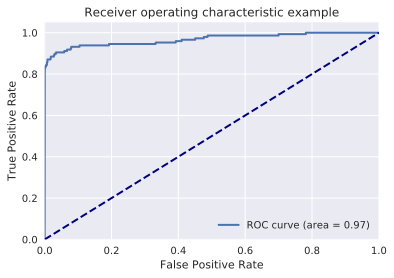

In [99]:
plot_roc_curve(y_test,soft_logit1)

**The roc score is quite good. We must tune the threshold to reduce the number of false alarms.** Let's plot the confusion matrix to have a better knowledge of false positive and false negative.

The number of false positive instances 12
The number of true positive instances 87
The nubmer of false negative instances 60
The number of true negative instances 85284
Normalized confusion matrix


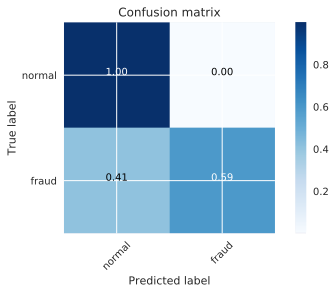

In [100]:
plot_confusion_matrix(y_test,hard_logit1, classes=['normal','fraud'],normalize=True)

The numbers are printed above the confusion matrix because proportion might be misleading. We can see that there are a lot of false positive instances. We will definitely want to reduce the number of false positive instances.

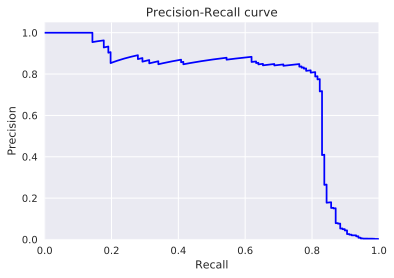

In [101]:
plot_precision_recall_curve(y_test,soft_logit1)

The precision recall curve give hint to tune the threshold for classification. The recall decreases drastically after a certain point. We should chose the appropriate threshold value with cross validation strategey. This is performed with **tune threshold** function defined in utility section.

In [102]:
thresholds = np.linspace(0.03,0.4,20)
tune_threshold(logit1,X_train.values,y_train.values,thresholds,3)

,auc,f1_score,precision,recall
0.030000,0.97376,0.773669,0.712607,0.846377
0.049474,0.97376,0.784540,0.754445,0.817391
0.068947,0.97376,0.786531,0.768442,0.805797
0.088421,0.97376,0.778824,0.772824,0.785507
0.107895,0.97376,0.774363,0.784038,0.765217
0.127368,0.97376,0.774783,0.787977,0.762319
0.146842,0.97376,0.770931,0.792413,0.750725
0.166316,0.97376,0.767706,0.795514,0.742029
0.185789,0.97376,0.757506,0.794211,0.724638
0.205263,0.97376,0.756729,0.795840,0.721739


We can chose the appropriate threshold value from the above data frame by observing the value of precision, recall and f1 score.

In [103]:
best_threshold = 0.049474
logit1.fit(X_train,y_train)
soft_logit1 = fraud_prob(logit1.soft_prediction(X_test))
hard_tuned_logit1 = soft_to_hard(soft_logit1,threshold=best_threshold) 
metrics_score(y_test,soft_logit1,threshold=best_threshold)

The roc score is:0.9674326586759258
The recall score is:0.7959183673469388
The f1 score is:0.806896551724138
The precision score is:0.8181818181818182


After tuning the value of threshold on 3 fold cross validation sample, we finally test it on test data set.

The number of false positive instances 26
The number of true positive instances 117
The nubmer of false negative instances 30
The number of true negative instances 85270
Normalized confusion matrix


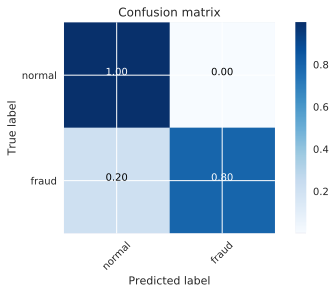

In [104]:
plot_confusion_matrix(y_test,hard_tuned_logit1,classes=['normal','fraud'],normalize=True,)

**We have maintain a pretty good balance between precision and recall by tuning threshold and thus good f1 score.**

In [108]:
### Lets train a classifier without using sampled  training set
logit2_params = {'random_state':0}

logit2 =   Model(LogisticRegression,params=logit2_params)
pred_logit2  = logit2.classifier_score(sampler=randomsampler,sampling=True)
soft_logit2 = fraud_prob(pred_logit2['soft'])
metrics_score(y_test,hard_predictions=pred_logit2['hard'])

The number of instances of each classes in resampled data Counter({0: 345, 1: 345})
The recall score is:0.9115646258503401
The f1 score is:0.0801675142087945
The precision score is:0.041927409261576974


The number of false positive instances 3062
The number of true positive instances 134
The nubmer of false negative instances 13
The number of true negative instances 82234
Normalized confusion matrix


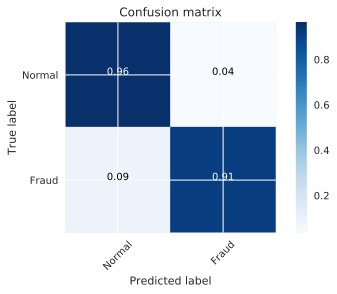

In [109]:
plot_confusion_matrix(y_test,pred_logit2['hard'],classes=['Normal','Fraud'],normalize=True)

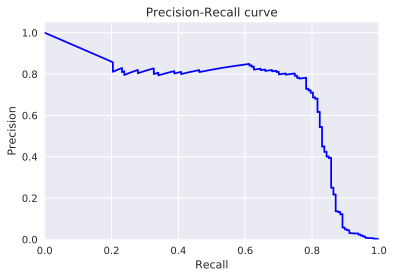

In [110]:
plot_precision_recall_curve(y_test,soft_logit2)

In [111]:
thresholds = np.linspace(0.03,0.4,20)
tune_threshold(logit2,X_train.values,y_train.values,thresholds,3)

,auc,f1_score,precision,recall
0.030000,0.97376,0.773669,0.712607,0.846377
0.049474,0.97376,0.784540,0.754445,0.817391
0.068947,0.97376,0.786531,0.768442,0.805797
0.088421,0.97376,0.778824,0.772824,0.785507
0.107895,0.97376,0.774363,0.784038,0.765217
0.127368,0.97376,0.774783,0.787977,0.762319
0.146842,0.97376,0.770931,0.792413,0.750725
0.166316,0.97376,0.767706,0.795514,0.742029
0.185789,0.97376,0.757506,0.794211,0.724638
0.205263,0.97376,0.756729,0.795840,0.721739


** Lets give a shot to svm model. **  We will try SVM model on undersampled data, and see if it could improve our recall score maintaining a good precision.

In [114]:
svm1_params = {'kernel': 'rbf','probability':True,'random_state':0}
svm1 = Model(SVC,params=svm1_params)
pred_svm1 = svm1.classifier_score(sampler=randomsampler, sampling=True)
soft_svm1 = fraud_prob(pred_svm1['soft'])
metrics_score(y_test,hard_predictions=pred_svm1['hard'])

The number of instances of each classes in resampled data Counter({0: 345, 1: 345})
The recall score is:0.9387755102040817
The f1 score is:0.017014980580728686
The precision score is:0.008585293019783502


**The performance of svm improve over logistic regression on using rbf kernel in terms of
recall score **. Let's plot the confusion matrix to have a closer look at classifier performance.  

The number of false positive instances 15936
The number of true positive instances 138
The nubmer of false negative instances 9
The number of true negative instances 69360
Normalized confusion matrix


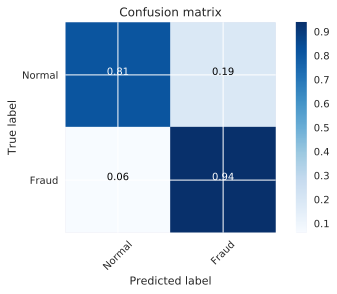

In [115]:
plot_confusion_matrix(y_test,pred_svm1['hard'],classes=['Normal','Fraud'],normalize=True)

We have reduced the number of false negative classes, but the number of false positive classes has increased drastically. Let's plot the precision-recall curve and see if could maintain good balance between by tunning the threshold value.

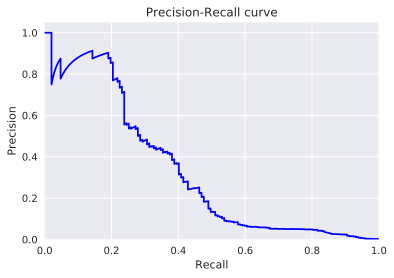

In [116]:
plot_precision_recall_curve(y_test,soft_svm1)

It seems that there is no point in tunning the threshold value. There is not any threshold as seen from the graph where there is a good balance between precision and recall. We will not spend time and computation power in tunning threshold.
** The data set highly imbalanced, so anomaly detection using one class SVM might work.  Let's try it.**

In [ ]:
def Bagging(estimator)

In [124]:
anomaly_svm_params = {'kernel':'linear','cache_size':1000,'random_state':0}
anomaly_svm = Model(OneClassSVM,params=anomaly_svm_params)
anomaly_svm.train(X_train,None)


In [127]:
soft_anomaly_svm = anomaly_svm.hard_prediction(X_test)

In [129]:
Counter(soft_anomaly_svm)

Counter({-1: 42700, 1: 42743})

### Ensembling 

In this section,several models tried in the previous section are combined to achieve a good balance between false positive and false negative score.

In [ ]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
thresholds = np.linspace(0.2,0.7,100)


In [ ]:
## Creating training set of meta features with and without Random Undersampling

meta_train1,meta_test1 = get_oof(clf=logit1,nfolds=3,
                                 sampler=randomsampler,sampling=True)

meta_train2,meta_test2 = get_oof(clf=logit2,nfolds=5,sampling=False)

In [ ]:
### Creating training and testing sets for meta features
n_metafeatures = 2
meta_train = np.zeros((X_train.shape[0], n_metafeatures))
meta_train[:,0]=meta_train1.ravel()
meta_train[:,1]=meta_train2.ravel()

meta_test = np.zeros((X_test.shape[0],n_metafeatures))
meta_test[:,0] = meta_test1.ravel()
meta_test[:,1] = meta_test2.ravel()


In [ ]:
#### Defining our meta model for second level ####
meta_model = LogisticRegression()
meta_model.fit(meta_train, y_train)
meta_pred = meta_model.predict_proba(meta_train)


In [ ]:
###### Getting the classification scores from our ensembled model ####
metrics_score(y_train,fraud_prob(meta_pred),threshold=0.5)

In [ ]:
#### tweaking the threshold value



